# House Price Prediction With TensorFlow

This example demonstrates how the Unfolded Map SDK allows for more engaging exploratory data visualization, helping to simplify the process of building a machine learning model for predicting median house prices in California.

## Dependencies 

This notebook uses the following dependencies:

- pandas
- numpy
- scikit-learn
- scipy
- seaborn
- matplotlib
- tensorflow

If those aren't already installed, run the following command:

```bash
pip install pandas numpy scikit-learn scipy seaborn matplotlib tensorflow
```

This notebook was originally tested with the following package versions, but likely works with a broad range of versions:

- pandas==1.3.2
- numpy==1.19.5
- scikit-learn==0.24.2
- scipy==1.7.1
- seaborn==0.11.2
- matplotlib==3.4.3
- tensorflow==2.6.0

## Imports

In [1]:
from uuid import uuid4

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.cluster.vq import vq
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Flatten, Softmax

from unfolded.map_sdk import UnfoldedMap

## Data Loading

For this example we'll use data from Kaggle's [California Housing Prices](https://www.kaggle.com/camnugent/california-housing-prices) dataset under the CC0 license.

In [2]:
dataset_url = "https://actionengine-public.s3.us-east-2.amazonaws.com/housing.csv"
housing = pd.read_csv(dataset_url)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Feature Engineering

First, let's take a look at the input data and try to visualize different aspects of them in a map.

### Population Clustering

Here we'll create a map that clusters by city with the largest population. Note that since the clustering happens within Unfolded Studio, the clusters change as you zoom in, allowing you to explore your data at various resolutions.

In [3]:
population_in_CA = UnfoldedMap()

# Create a persistent dataset ID that we can reference in both add_dataset and add_layer
dataset_id = uuid4()

population_in_CA.add_dataset(
    {"uuid": dataset_id, "label": "Population_in_CA", "data": housing},
    auto_create_layers=False,
)

population_in_CA.add_layer(
    {
        "id": "population_CA",
        "type": "cluster",
        "config": {
            "label": "population in CA",
            "data_id": dataset_id,
            "columns": {"lat": "latitude", "lng": "longitude"},
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {"name": "population", "type": "real"},
        },
    }
)

population_in_CA.set_view_state(
    {"longitude": -119.417931, "latitude": 36.778259, "zoom": 5}
)

population_in_CA

UnfoldedMap()

### Distance To Largest Cities

For example purposes, we'll take the five largest cities in California and compare our input data against these locations.

In [4]:
# Longitude-latitude pairs for large cities
cities = {
    "Los Angeles": (-118.244, 34.052),
    "San Diego": (-117.165, 32.716),
    "San Jose": (-121.895, 37.339),
    "San Francisco": (-122.419, 37.775),
    "Fresno": (-119.772, 36.748),
}

Next we need to find the closest city for each row in our data sample.

In [5]:
def distance(lng1, lat1, lng2, lat2):
    """Vectorized Haversine formula

    Computes distances between two sets of points.

    From: https://stackoverflow.com/a/51722117
    """
    # approximate radius of earth in km
    R = 6372.8

    lat1 = lat1*np.pi/180.0
    lng1 = np.deg2rad(lng1)
    lat2 = np.deg2rad(lat2)
    lng2 = np.deg2rad(lng2)

    d = np.sin((lat2 - lat1)/2)**2 + np.cos(lat1)*np.cos(lat2) * np.sin((lng2 - lng1)/2)**2

    return 2 * R * np.arcsin(np.sqrt(d))

In [6]:
def closest_city(lng_array, lat_array, cities):
    """Find the closest_city for each row in lng_array and lat_array input
    """
    distances = []

    # Compute distance from each row of arrays to each of our city inputs
    for city_name, coord in cities.items():
        distances.append(distance(lng_array, lat_array, *coord))

    # Convert this list of numpy arrays into a 2D numpy array
    distances = np.array(distances)

    # Find the shortest distance value for each row
    shortest_distances = np.amin(distances, axis=0)

    # Find the _index_ of the shortest distance for each row. Then use this value to
    # lookup the longitude-latitude pair of the closest city
    city_index = np.argmin(distances, axis=0)

    # Create a 2D numpy array of location coordinates
    # Then use the indexes from above to perform a lookup against the order of cities as
    # input. (Note: this relies on the fact that in Python 3.6+ dictionaries are
    # ordered)
    input_coords = np.array(list(cities.values()))
    closest_city_coords = input_coords[city_index]

    # Return a 2D array with three columns:
    # - Distance to closest city
    # - Longitude of closest city
    # - Latitude of closest city
    return np.hstack((shortest_distances[:, np.newaxis], closest_city_coords))

Then use the `closest_city` function on our data to create three new columns:

In [7]:
housing[['closest_city_dist', 'closest_city_lng', 'closest_city_lat']] = closest_city(
    housing['longitude'], housing['latitude'], cities
)

This map shows the distances between the locations and their nearest big cities

In [8]:
distance_to_big_cities = UnfoldedMap()
dist_data_id = uuid4()

distance_to_big_cities.add_dataset(
    {
        "uuid": dist_data_id,
        "label": "Distance to closest big cities",
        "data": housing,
    },
    auto_create_layers=False,
)

distance_to_big_cities.add_layer(
    {
        "id": "closest_distance",
        "type": "arc",
        "config": {
            "data_id": dist_data_id,
            "label": "distance to closest big cities",
            "columns": {
                "lng0": "longitude",
                "lat0": "latitude",
                "lng1": "closest_city_lng",
                "lat1": "closest_city_lat",
            },
            "visConfig": {"opacity": 0.8, "thickness": 0.3},
            "is_visible": True,
        },
    }
)

distance_to_big_cities.set_view_state(
    {"longitude": -119.417931, "latitude": 36.778259, "zoom": 4.5}
)

distance_to_big_cities

UnfoldedMap()

## Data Preprocessing

Here we are preparing data for training a TensorFlow model:

In [11]:
# we can drop null values as their count is less than 5 %
housing = housing.dropna()

X = pd.DataFrame(
    columns=[
        "longitude",
        "latitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income",
        "ocean_proximity",
    ],
    data=housing,
)
y = pd.DataFrame(columns=["median_house_value"], data=housing)

# converting ocean_proximity into new separate columns ('NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND')
X = pd.get_dummies(
    data=X, columns=["ocean_proximity"], prefix=["ocean_proximity"], drop_first=True
)

## Data Splitting

We split the data into training, validation and test sets

In [13]:
# dividing training data into test, validation and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1
)

start_values = X_test.copy(deep=True)

## Feature Scaling

We use standard scaling with mean and standard deviation from our training dataset to avoid data leakage

In [14]:
# feature standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Price Prediction Model

Here we are specify the parameters for the TensorFlow model:

In [15]:
model = Sequential()

number_of_features = X.shape[1]

# input Layer
model.add(Dense(number_of_features, activation="relu", input_dim=number_of_features))

# hidden Layer
model.add(Dense(512, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))

# output Layer
model.add(Dense(1, activation="linear"))

2021-09-17 09:20:41.741967: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 512)               6656      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2

### Training

Here we are starting the model training:

In [17]:
history = model.fit(
    X_train,
    y_train.to_numpy(),
    batch_size=10,
    epochs=70,
    verbose=1,
    validation_data=(X_val, y_val),
)

2021-09-17 09:21:02.707390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70
1226/1226 [==============================] - 3s 2ms/step - loss: 8909205504.0000 - mse: 8909205504.0000 - mae: 65358.1328 - val_loss: 5606605824.0000 - val_mse: 5606605824.0000 - val_mae: 54377.5742
Epoch 2/70
1226/1226 [==============================] - 3s 2ms/step - loss: 4940445184.0000 - mse: 4940445184.0000 - mae: 50409.5977 - val_loss: 5086661120.0000 - val_mse: 5086661120.0000 - val_mae: 48797.4961
Epoch 3/70
1226/1226 [==============================] - 3s 2ms/step - loss: 4486364160.0000 - mse: 4486364160.0000 - mae: 47773.7266 - val_loss: 4500957184.0000 - val_mse: 4500957184.0000 - val_mae: 47731.9766
Epoch 4/70
1226/1226 [==============================] - 3s 2ms/step - loss: 4276321280.0000 - mse: 4276321280.0000 - mae: 46616.4219 - val_loss: 4962499584.0000 - val_mse: 4962499584.0000 - val_mae: 53086.5664
Epoch 5/70
1226/1226 [==============================] - 3s 2ms/step - loss: 4063995904.0000 - mse: 4063995904.0000 - mae: 45257.5117 - val_loss: 4518308864.0000

### Evaluation

Here we are looking how well the model was trained:

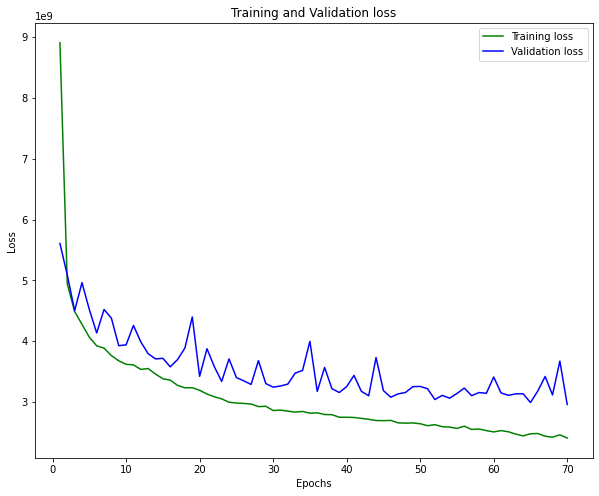

In [18]:
# summarize history for loss
loss_train = history.history["loss"]
loss_val = history.history["val_loss"]
epochs = range(1, 71)
plt.figure(figsize=(10, 8))
plt.plot(epochs, loss_train, "g", label="Training loss")
plt.plot(epochs, loss_val, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In the above chart we can see that the training loss and validation loss are quite close to each other.

Now we can use the model to predict prices on unseen data

In [19]:
y_pred = model.predict(X_test)

We can see that loss function value on the test data is similar to the loss value on the training data

In [20]:
model.evaluate(X_test, y_test)

128/128 [==============================] - 0s 1ms/step - loss: 2741234432.0000 - mse: 2741234432.0000 - mae: 35377.2344


[2741234432.0, 2741234432.0, 35377.234375]

### Prediction

Let's now visualize the predicted numbers on the map

First, create a dataframe with predicted values obtained from the model

In [21]:
predict_data = pd.DataFrame(
    columns=["longitude", "latitude"], data=start_values[["longitude", "latitude"]]
)
predict_data["price"] = y_pred

### Visualization

This map shows the predicted prices on houses in CA

In [22]:
housing_predict_prices = UnfoldedMap()
price_data_id = uuid4()

housing_predict_prices.add_dataset(
    {
        "uuid": price_data_id,
        "label": "Predict housing prices in CA",
        "data": predict_data,
    },
    auto_create_layers=False,
)

housing_predict_prices.add_layer(
    {
        "id": "housing_prices",
        "type": "hexagon",
        "config": {
            "label": "housing prices",
            "data_id": price_data_id,
            "columns": {"lat": "latitude", "lng": "longitude"},
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {"name": "price", "type": "real"},
            "vis_config": {
                "colorRange": {
                    "colors": [
                        "#E6F598",
                        "#ABDDA4",
                        "#66C2A5",
                        "#3288BD",
                        "#5E4FA2",
                        "#9E0142",
                        "#D53E4F",
                        "#F46D43",
                        "#FDAE61",
                        "#FEE08B",
                    ]
                }
            },
        },
    }
)

housing_predict_prices.set_view_state(
    {"longitude": -119.417931, "latitude": 36.6, "zoom": 6}
)

housing_predict_prices

UnfoldedMap()

## Clustering Model

Let's cluster the predicted data by price levels using the KMeans algorithm

In [23]:
k = 5
km = KMeans(n_clusters=k, init="k-means++")
X = predict_data[["latitude", "longitude", "price"]]

# clustering
dtf_X = X.copy()
dtf_X["cluster"] = km.fit_predict(X)

# add clustering info to the original dataset
predict_data[["cluster"]] = dtf_X[["cluster"]]

### Visualization

Let's show the price clusters in a chart

Text(0.5, 1.0, 'Clustering (k=5)')

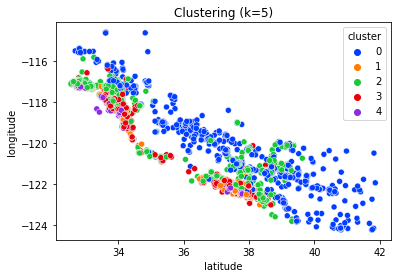

In [26]:
fig, ax = plt.subplots()
sns.scatterplot(
    x="latitude",
    y="longitude",
    data=predict_data,
    palette=sns.color_palette("bright", k),
    hue="cluster",
    size_order=[1, 0],
    ax=ax,
).set_title(f"Clustering (k={k})")

This map shows the same clusters in the geographic context

Here we can see that the prices for cities close to the largest cities are the highest, in contrast to those that are far from them and, moreover, far from the ocean.

In [25]:
prices_dataset_id = uuid4()
unfolded_map_prices = UnfoldedMap()

unfolded_map_prices.add_dataset(
    {"uuid": prices_dataset_id, "label": "Prices", "data": predict_data},
    auto_create_layers=False,
)

unfolded_map_prices.add_layer(
    {
        "id": "prices_CA",
        "type": "point",
        "config": {
            "data_id": prices_dataset_id,
            "label": "clustering of prices",
            "columns": {"lat": "latitude", "lng": "longitude"},
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {"name": "cluster", "type": "real"},
            "vis_config": {
                "colorRange": {
                    "colors": ["#7FFFD4", "#8A2BE2", "#00008B", "#FF8C00", "#FF1493"]
                }
            },
        },
    }
)

unfolded_map_prices.set_view_state(
    {"longitude": -119.417931, "latitude": 36.778259, "zoom": 4}
)

unfolded_map_prices

UnfoldedMap()